# Notes
- Different species
- Gap phase replacement
- Spatial field

# To-do
- Inform initial spatial and size distributions
- Inform reproductive mechanism (range, probability, etc.)
- Inform mortality mechanism
- Make the viewer more interactive (zoom and move around, play, reverse, speed up, slow down)
- ~~Write your own quadtree class and add a method for removing objects from it to speed up collision detection~~
- ~~Implement plant reproduction (either as a method in the Plant class or in the Simulation class)~~
- ~~Fix new plant spawns showing up for one frame and then getting killed~~
- ~~Add find collisions to Simulation class~~
- ~~Move plants list and states list to Simulation class~~
- ~~Fix Plant .kill() method~~
- ~~replace .update_color() method to set_color() in Plant class~~
- ~~add simulation.step() method to Simulation class~~

# Intersection probability (unfinished)
### Probability of a Point Inside Circles in a Square
**Problem Setup**
- Square with side length $S$
- $N$ circles with radii uniformly distributed between $r_{min}$ and $r_{max}$
- Find the probability that a new random point $p$ is inside at least one circle

**1. Expected Area of a Single Circle**

$$E[A] = \pi E[r^2] = \pi(r_{min}^2 + r_{max}^2 + r_{min}r_{max}) / 3$$

**2. Total Expected Area Covered by Circles**

$$E[A_\mathrm{total}] = N \cdot E[A]$$

**3. Probability Calculation**

The probability of the point being inside a circle is equal to the fraction of the square's area that is covered by circles, on average:

$$P(p \text{ inside at least one circle}) = \frac{E[A_\mathrm{total}]}{S^2} = \frac{N \cdot \pi \cdot (r_{min}^2 + r_{max}^2 + r_{min}r_{max})}{3S^2}$$

**4. Edge Cases**

- If $E[A_\mathrm{total}] > S^2$, cap the probability at 1
- The formula assumes circles can overlap and extend beyond the square's boundaries

## Notes

This approach uses the concept of expected value and assumes that the circles are placed randomly and independently. It's an average case analysis - the actual probability for a specific configuration of circles might differ.

For very large $N$ or when circles are large relative to the square, this simple formula might overestimate the probability due to increased overlap. In such cases, more sophisticated models from continuum percolation theory might be needed.

## Key Reference

Hall, P. (1988). Introduction to the Theory of Coverage Processes. John Wiley & Sons.

This book discusses various aspects of coverage problems, including the one we've just solved.



*WRITTEN BY CLAUDE AI*

**Define the problem parameters.**
- Square side length: $S$
- Number of circles: $N$
- Distribution of circle radii: Let's assume a uniform distribution between $r_\mathrm{min}$ and $r_\mathrm{max}$ for simplicity


**Expected area of a single circle.**
$$E[A] = \pi \cdot E[r^2]$$
For a uniform distribution: $E[r^2] = (r_\mathrm{min}^2 + r_\mathrm{max}^2 + r_\mathrm{min}r_\mathrm{max}) / 3$


**Total expected area covered by all circles.**
$$E[A_\mathrm{total}] = N \cdot E[A]$$

**Probability of a random point being covered by at least one circle**
$$P(\mathrm{covered}) = 1 - \exp\left(-\frac{E[A_\mathrm{total}]}{S^2}\right)$$

This step uses the void (avoidance) probability from the Boolean model in stochastic geometry. The $\exp(-\mathrm{density})$ term gives the probability of a point not being covered by any circle (which is exactly the void probability).
The probability of overlap is related to this coverage probability. If the circles are independently placed, we can approximate the probability of overlap as:

$$P(\mathrm{overlap}) ≈ 1 - (1 - P(\mathrm{covered}))^N$$

This is because for no overlap to occur, each circle must fall entirely in the uncovered region of all previous circles.
For more accurate results, especially with larger circles or higher densities, you'd need to account for edge effects and higher-order interactions. This often requires numerical simulations or more advanced analytical techniques.


Let's summarize into one equation

$$P(\mathrm{overlap}) = 1 - \exp\left( -\frac{E[A_\mathrm{total}]}{S^2} \right)^N = 1 - \exp\left(- \frac{N\pi}{3} \cdot \frac{r_\mathrm{min}^2 + r_\mathrm{max}^2 + r_\mathrm{min}r_\mathrm{max}}{S^2} \right)^N$$

In [37]:
import numpy as np
import matplotlib.pyplot as plt


def diff(EA, A_box, Q_land, Π_species, Π_death):
    def dPdt(P, t):
        density = P * EA / A_box

        Π_point = (1 - density)
        Π_overlap = (1 - np.exp(-density))

        Π_reproduction = Π_point * (density + Q_land) * Π_species

        Π_competition = Π_overlap/2

        # print(density, Π_reproduction, Π_competition, Π_death, Π_reproduction - Π_competition - Π_death)
        
        return P * (Π_reproduction - Π_competition - Π_death)
    return dPdt

n_iter = 1000
P = num_plants = 1_000
S = 1_000 # m

A_box = S**2

growth_rate = 0.1
r_min = 0.01
r_max = 30
Π_death = growth_rate/(r_max - r_min)

dPdt = diff(EA=EA, A_box=A_box, Q_land=-0.1, Π_species=0.2, Π_death=Π_death)

P = P0 = N
Ps = [P0]
for t in range(n_iter):
    P += dPdt(P, t)
    if P < 0:
        P = 0

    Ps.append(P)

plt.plot(Ps)

NameError: name 'EA' is not defined

In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
rs = np.array([np.random.rand() for i in range(1000)])
r_mean = np.mean(rs)
r2_mean = np.mean(rs**2)

print(f'{r_mean = :.3f}, {r2_mean = :.3f}, {r_mean**2 = :.3f}, {np.sqrt(r2_mean) = :.3f}')

r_mean = 0.499, r2_mean = 0.335, r_mean**2 = 0.249, np.sqrt(r2_mean) = 0.579


shape = (5, 5)
(121, 2)

field = 
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

field_fine = 
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.08 0.24 0.4  0.24 0.08 0.   0.   0.  ]
 [0.   0.   0.   0.16 0.48 0.8  0.48 0.16 0.   0.   0.  ]
 [0.   0.   0.   0.16 0.48 0.8  0.48 0.16 0.   0.   0.  ]
 [0.   0.   0.   0.08 0.24 0.4  0.24 0.08 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


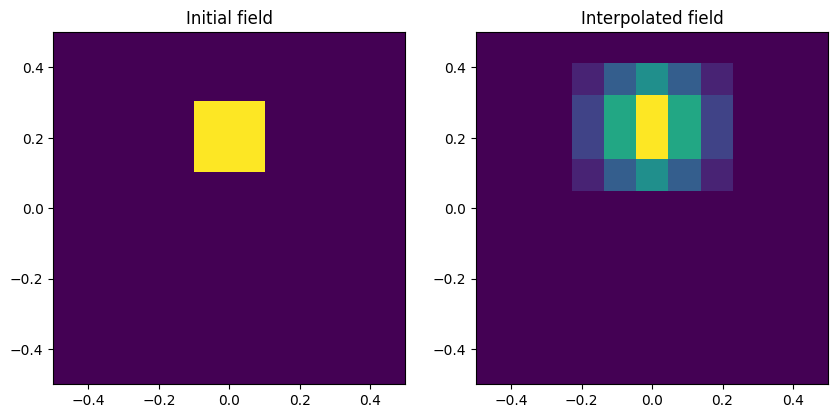

In [34]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt

half_width = 0.5
half_height = 0.5
resolution = 5
shape = (I, J) = (resolution, resolution)
print(f'{shape = }')

field = np.zeros(shape)
field[shape[0]//2 - resolution//4, shape[1]//2] = 1
xx = np.linspace(-half_width, half_width, resolution)
yy = np.linspace(-half_height, half_height, resolution)

# Create an interpolating function
interp_func = RegularGridInterpolator((xx, yy), field, method='linear')

# Define finer resolution
fine_resolution = 11
xx_fine = np.linspace(-half_width, half_width, fine_resolution)
yy_fine = np.linspace(-half_height, half_height, fine_resolution)

# Interpolate the field
X_fine, Y_fine = np.meshgrid(xx_fine, yy_fine)
points_fine = np.array([X_fine.flatten(), Y_fine.flatten()]).T
print(points_fine.shape)
field_fine = interp_func(points_fine).reshape(fine_resolution, fine_resolution).T

print()
print(f'field = \n{np.round(field, 2)}')
print()
print(f'field_fine = \n{np.round(field_fine, 2)}')


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(field, origin='upper', extent=(-half_width, half_width, -half_height, half_height))
ax[0].set_aspect('equal', adjustable='box')
# fig.colorbar(ax[0].collections[0], ax=ax[0])
ax[0].set_title('Initial field')

ax[1].imshow(field_fine, origin='upper', extent=(-half_width, half_width, -half_height, half_height))
ax[1].set_aspect('equal', adjustable='box')
# fig.colorbar(ax[1].collections[0], ax=ax[1])
ax[1].set_title('Interpolated field')

plt.show()

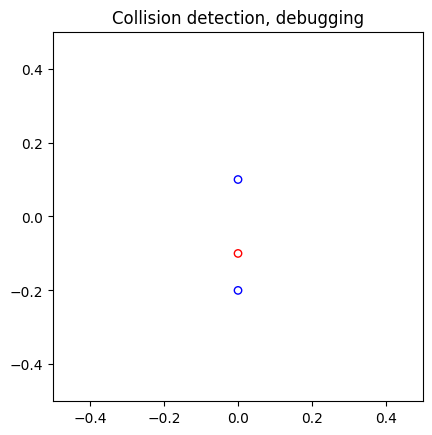

indices = [0, 1]
[(array([ 0. , -0.2]), 0.01), (array([0. , 0.1]), 0.01), (array([ 0. , -0.1]), 0.01)]
[(array([ 0. , -0.2]), 0.01), (array([0. , 0.1]), 0.01)]
[False False]
no collision
1


: 

In [41]:
from plant import Plant

def check_pos_collision(pos, plant):
    return np.sum((pos - plant.pos) ** 2) < plant.r ** 2

plant_kwargs = {
    'r_min': 0.01,
    'r_max': 30,
    'growth_rate': 0.01,
    'dispersal_range': 100,
    'species_germination_chance': 0.025,
}

plants = [Plant(np.array([0, -0.2]), **plant_kwargs), Plant(np.array([0, 0.1]), **plant_kwargs), Plant(np.array([0.0, -0.1]), **plant_kwargs)]
this_plant = plants[-1]

fig, ax = plt.subplots()
for plant in plants:
    ec = 'r' if plant == this_plant else 'b'
    circle = plt.Circle(plant.pos, plant.r, edgecolor=ec, facecolor='none')
    ax.add_patch(circle)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_aspect('equal', 'box')
plt.title('Collision detection, debugging')
plt.show()

indices = [j for j, other in enumerate(plants) if other != this_plant]
print(f'{indices = }')
plants_nearby = [plants[i] for i in indices]
print([(plant.pos, plant.r) for plant in plants])
print([(plant.pos, plant.r) for plant in plants_nearby])

collisions_nearby = np.array([check_pos_collision(this_plant.pos, plant) for plant in plants_nearby])
print(collisions_nearby)

p = None
if len(plants_nearby) == 0:
    p =  0
elif collisions_nearby.any():
    print('collision')
    p =  0
else:
    print('no collision')
    p = 1
    
print(p)

In [46]:
import numpy as np
times = []
size = 5
skip = 20
preset_times = [1, 25]

fields = np.zeros((size, 1, 1))

def add(field, t):
    global fields, times
    if len(times) == size:
        for i, time in enumerate(times):
            if time not in preset_times:
                print(f'{time = } not in {preset_times = }')
                B = np.roll(fields[i:], -1, axis=0)
                fields = np.concatenate((fields[:i], B), axis=0)
                times.pop(i)
                break
          
    fields[len(times)] = field
    times.append(t)

for t in range(0, 200):
    if t % skip == 0 or t in preset_times:
        
        add(field=np.ones(fields.shape[-2:]) * t, t=t)
        print(f'{t = }')
        print(f'{times = }')
        print(f'{fields = }')
        

# print(fields)
# print(times)


t = 0
times = [0]
fields = array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]]])
t = 1
times = [0, 1]
fields = array([[[0.]],

       [[1.]],

       [[0.]],

       [[0.]],

       [[0.]]])
t = 20
times = [0, 1, 20]
fields = array([[[ 0.]],

       [[ 1.]],

       [[20.]],

       [[ 0.]],

       [[ 0.]]])
t = 25
times = [0, 1, 20, 25]
fields = array([[[ 0.]],

       [[ 1.]],

       [[20.]],

       [[25.]],

       [[ 0.]]])
t = 40
times = [0, 1, 20, 25, 40]
fields = array([[[ 0.]],

       [[ 1.]],

       [[20.]],

       [[25.]],

       [[40.]]])
time = 0 not in preset_times = [1, 25]
t = 60
times = [1, 20, 25, 40, 60]
fields = array([[[ 1.]],

       [[20.]],

       [[25.]],

       [[40.]],

       [[60.]]])
time = 20 not in preset_times = [1, 25]
t = 80
times = [1, 25, 40, 60, 80]
fields = array([[[ 1.]],

       [[25.]],

       [[40.]],

       [[60.]],

       [[80.]]])
time = 40 not in preset_times = [1, 25]
t = 100
times = [1, 25, 60, 80, 10

In [11]:
import numpy as np
ts = []
size = 4
A = np.ones((size, 2, 2))

for j in range(len(A)):
    A[j] = A[j] * j
    ts.append(j)

print(A)
print(ts)

i = 1  # could be any number

A[i] = np.ones(A.shape[-2:]) * (len(A))
B = np.roll(A[i:], (-i), axis=0)
A = np.concatenate((A[:i], B), axis=0)
ts.pop(i)
ts.append(len(A))

print()
print(A)
print(ts)

[[[0. 0.]
  [0. 0.]]

 [[1. 1.]
  [1. 1.]]

 [[2. 2.]
  [2. 2.]]

 [[3. 3.]
  [3. 3.]]]
[0, 1, 2, 3]

[[[0. 0.]
  [0. 0.]]

 [[2. 2.]
  [2. 2.]]

 [[3. 3.]
  [3. 3.]]

 [[4. 4.]
  [4. 4.]]]
[0, 2, 3, 4]


# Sampling lifetime uniformly is equivalent to sampling radii uniformly because

$$T(r) = \frac{r_{\mathrm{max}} - r}{g}, \qquad \text{where } g \text{ is the constant growth rate}$$

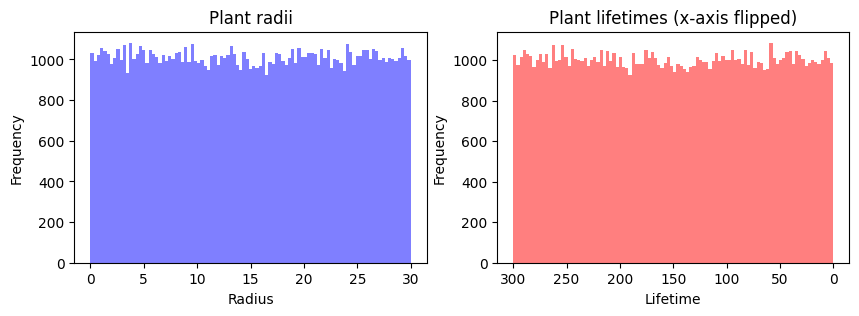

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

growth_rate = 0.1
r_min = 0.00
r_max = 30

rs = np.array([np.random.uniform(r_min, r_max) for i in range(100_000)])

lifetimes = (r_max - rs)/growth_rate

fig, ax = plt.subplots(1,2 , figsize=(10, 3))
bins = np.linspace(0, r_max, 100)
ax[0].set_title('Plant radii')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Radius')
ax[0].hist(rs, bins=bins, alpha=0.5, color='b');

bins = np.linspace(0, (r_max - r_min)/growth_rate, 100)
ax[1].set_title('Plant lifetimes (x-axis flipped)')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Lifetime')
ax[1].hist(lifetimes, bins=100, alpha=0.5, color='r');
ax[1].invert_xaxis()


The total density of trees in all forests is 	 6719.000 trees/ha or 	 1.488 m^2/tree
The total density of trees in dense forests is 	 6250.280 trees/ha or 	 1.600 m^2/tree
The total density of trees in open forests is 	 7928.700 trees/ha or 	 1.261 m^2/tree


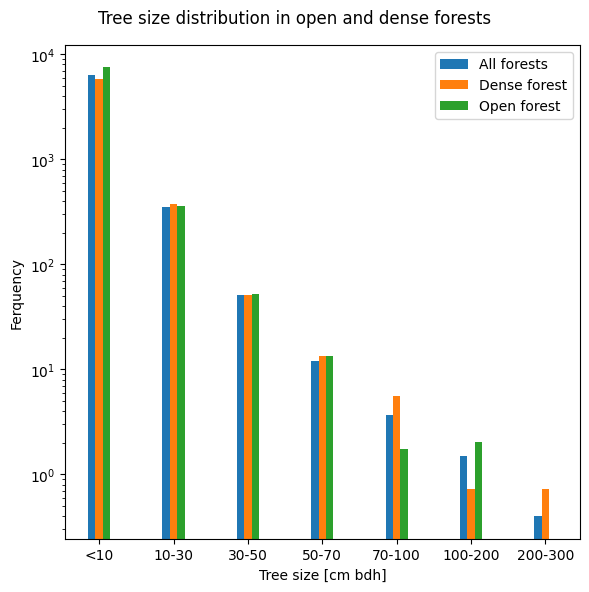

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#### FOLLOWING TABLE 5 FROM CUMMINGS ET AL. (2002) ####

names = ['<10', '10-30', '30-50', '50-70', '70-100', '100-200', '200-300']
freq_all_forests = np.array([6300, 350.7, 50.70, 12.0, 3.7, 1.5, 0.4])
freq_dense_forest = np.array([5800, 378.8, 50.98, 13.42, 5.62, 0.73, 0.73])
freq_open_forest = np.array([7500, 359.5, 51.90, 13.49, 1.75, 2.06, 0])

print(f'The total density of trees in all forests is \t {np.sum(freq_all_forests):.3f} trees/ha or \t {10_000/np.sum(freq_all_forests):.3f} m^2/tree')
print(f'The total density of trees in dense forests is \t {np.sum(freq_dense_forest):.3f} trees/ha or \t {10_000/np.sum(freq_dense_forest):.3f} m^2/tree')
print(f'The total density of trees in open forests is \t {np.sum(freq_open_forest):.3f} trees/ha or \t {10_000/np.sum(freq_open_forest):.3f} m^2/tree')


fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Define the width of the bars
bar_width = 0.1

# Calculate the positions for each set of bars
x = np.arange(len(names))
x_all_forests = x - bar_width
x_dense_forest = x
x_open_forest = x + bar_width

# Plot the bars
ax.bar(x_all_forests, freq_all_forests, width=bar_width, label='All forests', align='center')
ax.bar(x_dense_forest, freq_dense_forest, width=bar_width, label='Dense forest', align='center')
ax.bar(x_open_forest, freq_open_forest, width=bar_width, label='Open forest', align='center')

# Set the x-ticks to the middle of the groups
ax.set_xticks(x)
ax.set_xticklabels(names)

ax.set_yscale('log')
ax.set_xlabel('Tree size [cm bdh]')
ax.set_ylabel('Ferquency')
ax.legend()

fig.suptitle('Tree size distribution in open and dense forests')
fig.tight_layout()
plt.show()



# Kernel density estimation for plant size distribution

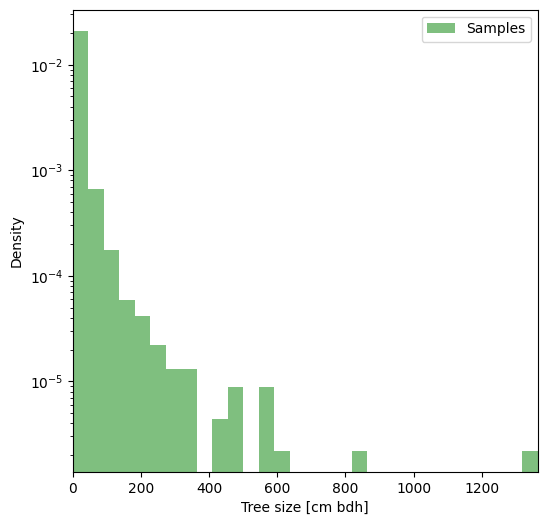

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#### FOLLOWING TABLE 5 FROM CUMMINGS ET AL. (2002) ####

names = ['<10', '10-30', '30-50', '50-70', '70-100', '100-200', '200-300']
means = np.array([5, 20, 40, 60, 85, 150, 250])
freqs = np.array([5800, 378.8, 50.98, 13.42, 5.62, 0.73, 0.73])

# Apply log transformation to the data
log_means = np.log(means)

# Calculate the KDE of the log-transformed data
kde = gaussian_kde(log_means, weights=freqs, bw_method='silverman')

# # Define the range of the KDE in the original space
# x = np.linspace(0.1, 10000, 10000)  # Avoid log(0) by starting from a small positive value
# log_x = np.log(x)
# y = kde(log_x) / x  # Adjust the KDE values for the log transformation

# Resample from the KDE and transform back to the original space
num_plants = 10000
log_samples = kde.resample(num_plants)[0]
samples = np.exp(log_samples)

# Plot the histogram of the samples
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(samples, bins=30, density=True, alpha=0.5, color='g', label='Samples')
# ax.plot(x, y, label='KDE', color='r')
ax.set_xlim(0, samples.max())
ax.set_yscale('log')
ax.set_xlabel('Tree size [cm bdh]')
ax.set_ylabel('Density')
ax.legend()
plt.show()

# Kernel density estimation for plant density

n = 100, _m = 0.001
res = np.int64(354)


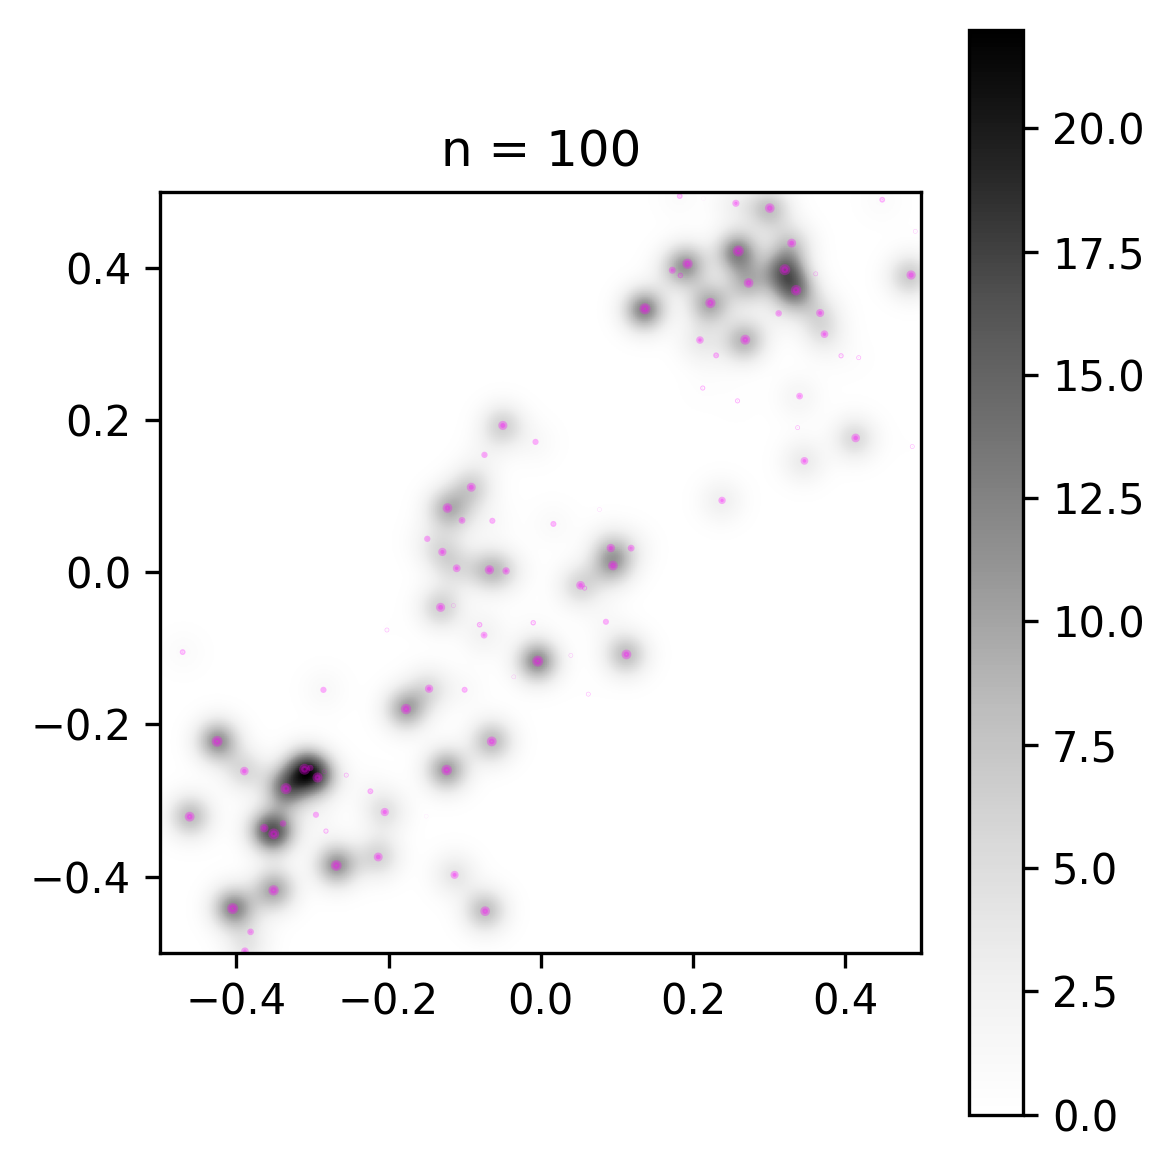

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.spatial import KDTree
from scipy.stats import gaussian_kde as kde

class custom_kde(gaussian_kde):
    def __init__(self, dataset, bw_method=None, weights=None):
        super().__init__(dataset, bw_method=bw_method, weights=weights)

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        self._data_covariance = np.eye(self.dataset.shape[0])
        self._data_cho_cov = np.eye(self.dataset.shape[0])
        self.covariance = self._data_covariance * self.factor**2
        self.cho_cov = (self._data_cho_cov * self.factor).astype(np.float64)
        self.log_det = 2*np.log(np.diag(self.cho_cov
                                        * np.sqrt(2*np.pi))).sum()

np.random.seed(0)
m2pp = 10000
ns = [10, 100, 1000]

for i, n in enumerate(ns[1:2]):
    fig, ax = plt.subplots(figsize=(4, 4))
    _m = float(np.sqrt(1/(m2pp * n)))
    print(f'{n = }, {_m = }')
    # Define the grid on which to evaluate the KDE

    positions1 = np.random.normal(loc=[-0.3, -0.3], scale=0.1, size=(n//3, 2))
    positions2 = np.random.normal(loc=[0.3, 0.3], scale=0.1, size=(n//3, 2))
    positions3 = np.random.normal(loc=[0.0, 0.0], scale=0.1, size=(n//3, 2))
    positions = np.concatenate((positions1, positions2, positions3), axis=0)
    positions = positions[(positions[:, 0] >= -0.5) & (positions[:, 0] <= 0.5) & (positions[:, 1] >= -0.5) & (positions[:, 1] <= 0.5)]
    kt = KDTree(positions, leafsize=10)
    areas = np.pi* (np.random.uniform(0.01, 30, len(positions)) * _m)**2

    bw = 20*_m
    res = np.ceil(10/ (np.sqrt(2) * bw)).astype(int)
    res = max(60, res)
    
    print(f'{res = }')

    x = np.linspace(-0.5, 0.5, res)
    X, Y = np.meshgrid(x, x)
    XY_vstack = np.vstack([X.ravel(), Y.ravel()])

    # Calculate the kernel density estimate
    kde = custom_kde(positions.T, bw_method=bw, weights=areas)
    Z = kde(XY_vstack).reshape(X.shape)
    im = ax.imshow(Z, origin='lower', extent=(x[0], x[-1], x[0], x[-1]), cmap='Greys')
    # ax.contour(X, Y, Z, levels=[0.1, 0.5, 1.0], colors=['r', 'g', 'b'][::-1], alpha = 0.5, linewidths=1000*_m)
    ax.scatter(positions[:, 0], positions[:, 1], s=areas*1000, c='magenta', alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'n = {n}')
    fig.colorbar(im, ax=ax)

fig.dpi = 300
fig.tight_layout()


n = 10, _m = 0.0031622776601683794
res = 100
n = 100, _m = 0.001
res = 100
n = 1000, _m = 0.00031622776601683794
res = 100


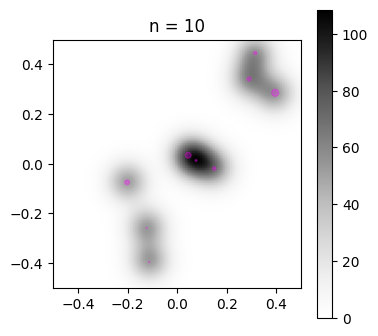

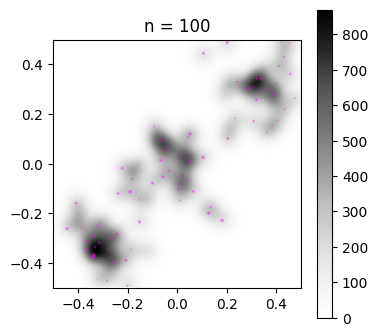

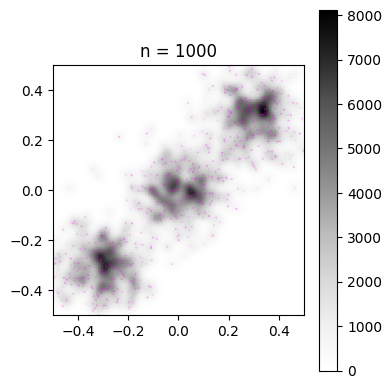

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
np.random.seed(0)
m2pp = 10000
ns = [10, 100, 1000]

for i, n in enumerate(ns):
    fig, ax = plt.subplots(figsize=(4, 4))
    _m = float(np.sqrt(1/(m2pp * n)))
    print(f'{n = }, {_m = }')
    # Define the grid on which to evaluate the KDE

    positions1 = np.random.normal(loc=[-0.3, -0.3], scale=0.1, size=(n//3, 2))
    positions2 = np.random.normal(loc=[0.3, 0.3], scale=0.1, size=(n//3, 2))
    positions3 = np.random.normal(loc=[0.0, 0.0], scale=0.1, size=(n//3, 2))
    positions = np.concatenate((positions1, positions2, positions3), axis=0)
    positions = positions[(positions[:, 0] >= -0.5) & (positions[:, 0] <= 0.5) & (positions[:, 1] >= -0.5) & (positions[:, 1] <= 0.5)]
    kt = KDTree(positions)
    areas = np.pi* (np.random.uniform(0.01, 30, len(positions)) * _m)**2

    bw = np.sqrt(_m)
    res = 100
    
    print(f'{res = }')

    x = np.linspace(-0.5, 0.5, res)
    X, Y = np.meshgrid(x, x)
    XY_vstack = np.vstack([X.ravel(), Y.ravel()])

    # # Calculate the kernel density estimate
    # kde = gaussian_kde(positions.T, bw_method=bw, weights=areas)
    Z = kt.kernel_density(XY_vstack.T, h=bw).reshape(X.shape)
    im = ax.imshow(Z, origin='lower', extent=(x[0], x[-1], x[0], x[-1]), cmap='Greys')
    # ax.contour(X, Y, Z, levels=[0.1, 0.5, 1.0], colors=['r', 'g', 'b'][::-1], alpha = 0.5, linewidths=1000*_m)
    ax.scatter(positions[:, 0], positions[:, 1], s=areas*1000, c='magenta', alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'n = {n}')
    fig.colorbar(im, ax=ax)

fig.tight_layout()


# Parsing of simulation print statements

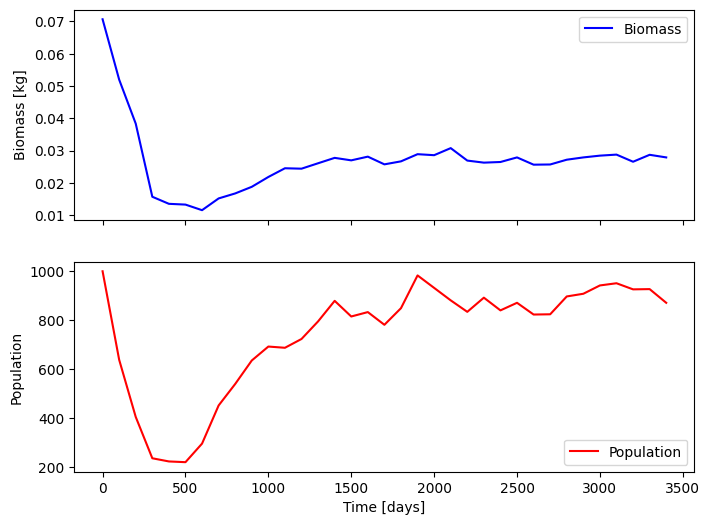

In [5]:
import numpy as np
import matplotlib.pyplot as plt
data = """
| t =   0         |       P =  1000       |       B = 0.07068     |
| t =  100        |       P =  638        |       B = 0.05198     |
| t =  200        |       P =  404        |       B = 0.03833     |
| t =  300        |       P =  235        |       B = 0.01568     |
| t =  400        |       P =  222        |       B = 0.01349     |
| t =  500        |       P =  219        |       B = 0.01325     |
| t =  600        |       P =  295        |       B = 0.01152     |
| t =  700        |       P =  451        |       B = 0.01516     |
| t =  800        |       P =  539        |       B = 0.01671     |
| t =  900        |       P =  635        |       B = 0.01876     |
| t = 1000        |       P =  692        |       B = 0.02181     |
| t = 1100        |       P =  687        |       B = 0.02451     |
| t = 1200        |       P =  723        |       B = 0.02438     |
| t = 1300        |       P =  795        |       B = 0.02606     |
| t = 1400        |       P =  879        |       B = 0.02773     |
| t = 1500        |       P =  815        |       B = 0.02696     |
| t = 1600        |       P =  833        |       B = 0.02811     |
| t = 1700        |       P =  781        |       B = 0.02572     |
| t = 1800        |       P =  849        |       B = 0.02665     |
| t = 1900        |       P =  983        |       B = 0.02887     |
| t = 2000        |       P =  932        |       B = 0.02856     |
| t = 2100        |       P =  881        |       B = 0.03075     |
| t = 2200        |       P =  834        |       B = 0.02689     |
| t = 2300        |       P =  892        |       B = 0.02625     |
| t = 2400        |       P =  840        |       B = 0.02645     |
| t = 2500        |       P =  871        |       B = 0.02787     |
| t = 2600        |       P =  823        |       B = 0.02562     |
| t = 2700        |       P =  824        |       B = 0.02568     |
| t = 2800        |       P =  897        |       B = 0.02716     |
| t = 2900        |       P =  908        |       B = 0.02787     |
| t = 3000        |       P =  942        |       B = 0.02842     |
| t = 3100        |       P =  951        |       B = 0.02874     |
| t = 3200        |       P =  926        |       B = 0.02653     |
| t = 3300        |       P =  927        |       B = 0.02868     |
| t = 3400        |       P =  871        |       B = 0.02787     |
"""

# Parse the data
rows = data.strip().split('\n')
parsed_data = []

for row in rows:
    parts = row.split('|')
    t = int(parts[1].split('=')[1].strip())
    P = int(parts[2].split('=')[1].strip())
    B = float(parts[3].split('=')[1].strip())
    parsed_data.append([t, P, B])

parsed_data = np.array(parsed_data)

# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[1].plot(parsed_data[:, 0], parsed_data[:, 1], label='Population', color='r')
ax[1].set_ylabel('Population')
ax[0].plot(parsed_data[:, 0], parsed_data[:, 2], label='Biomass', color='b')
ax[1].set_xlabel('Time [days]')
ax[0].set_ylabel('Biomass [kg]')
ax[1].legend()
ax[0].legend()
plt.show()